<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Image Classification Project

The objective of the project is to build a Convolutional Neural Network model to classify fashion product images using TensorFow and Keras functional API.  The model will then predict the class of a given input image.

The dataset can be downloaded from https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

The platform selected for the project is Google Collab.

Different optimization techniques will be used to yield a classification system that is robust enough to address the needs of businesses requiring  a product catalog to classify items in an efficient and automated manner.





In [1]:
# Install TensorFlow
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# importing additional libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

# Mounting to Google Drive

In [3]:
# Path to fashion product images files on Google Drive

DATASET_PATH = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [4]:
# Reading df_style pandas dataframe which contains images attributes
# Some rows have an extra column in their productDisplayName which will be ommitted.
df_styles = pd.read_csv(DATASET_PATH + 'styles.csv', usecols = lambda column : column not in range(11))

df_styles['image'] = df_styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)

df_styles['masterCategory'] = df_styles.masterCategory.apply(lambda row: 'NA' if row is np.nan else row)

There are 7 distinct product categories in the dataset.  As shown below, the categories are unevenly distributed.  The data will need to be stratified for balance.

In [5]:
df_styles.masterCategory.value_counts()


Apparel           21400
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [6]:
# Home and Sporting Goods classes will be added to Free Items class due low number of samples in the class

new_class_assignment = {'Home':'Free Items', 'Sporting Goods': 'Free Items'}
df_styles = df_styles.replace(new_class_assignment)

In [7]:
df_styles.masterCategory.value_counts()

Apparel          21400
Accessories      11289
Footwear          9222
Personal Care     2404
Free Items         131
Name: masterCategory, dtype: int64

Splitting dataset into train, validation and test subsets where each subset is stratisfied by the values in the masterCategory column of df_styles dataframe


In [8]:
# function to stratify train, validation and test data in 5 classes

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.70, frac_val=0.10, frac_test=0.20,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    where each subset is stratified by the values in a specific column. 


    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_styles.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_validation, df_test, y_validation, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_validation) + len(df_test)

    return df_train, df_validation, df_test

In [9]:
# Splitting data

df_train, df_validation, df_test = \
    split_stratified_into_train_val_test(df_styles, stratify_colname='masterCategory', frac_train=0.70, frac_val=0.10, frac_test=0.20)

In [10]:
# Creating a control group that will be used as unseen data for the model ensemble later in the project

y_test = df_test.masterCategory
df_test_subset, df_control_subset, y_test_subset, y_control_subset = train_test_split(df_test, y_test, test_size=.50, stratify=y_test)

In [11]:
print('The train subset has', len(df_train),'samples')
print('The validation subset has', len(df_validation),'samples')
print('The test subset has', len(df_test_subset),'samples')
print('The control subset has', len(df_control_subset),'samples')

The train subset has 31112 samples
The validation subset has 4444 samples
The test subset has 4445 samples
The control subset has 4445 samples


There are five unique categories in the masterCategory column that will be used as classes in the model.

In [12]:
df_train.masterCategory.value_counts()

Apparel          14980
Accessories       7902
Footwear          6455
Personal Care     1683
Free Items          92
Name: masterCategory, dtype: int64

In [13]:
# number of classes in masterCategory column of df_train
K = len(set(df_train.iloc[:,2]))
print('The number of classes is', K)

The number of classes is 5


In [14]:
# Path to images folder
images_data = DATASET_PATH+"images/"

# Mapping images to MasterCategory classes in df_styles using ImageDataGenerator

In [15]:
# Using ImageDataGenerator to correlate images from image folder to masterCategory column in df_train, df_validation and df_test 

from keras.preprocessing.image import ImageDataGenerator
HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                    dataframe=df_train,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items'],
                    target_size=(HEIGHT,WIDTH))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_validation,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items'],
                    target_size=(HEIGHT,WIDTH))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test_subset,
                    directory=images_data,
                    x_col="image",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(HEIGHT,WIDTH))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 10 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 31102 validated image filenames belonging to 5 classes.
Found 4444 validated image filenames belonging to 5 classes.
Found 4445 validated image filenames.


# Building the Convolutional Neural Network Model

The input image is 80x60 in size with an RGB channel. We will build a CNN model with a convolution + pooling architecture, followed by a number of fully connected Dense layers. 

The activation function for the convolutional layers will be ReLU ((Rectified Linear Units). 

The output layer will utilize a softmax activation function for the multiclass classification.

The hyperparameters that will be used are:
MaxPooling2d(2, 2) which extracts certain features from the image and reduces its height and the width. By using 2 pooling layers, the height and width are 1/4 of the original sizes.

BatchNormalization which regularizes and makes the training of convolutional neural networks more efficient.

Dropout to avoid overfitting



In [16]:

  #Model architecture
  # 2D convolutional layer with 2 spatial dimensions (height and width)
  # Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
  # 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
  # A 3D filter with 3x3x3 dimensions
  # A ReLU activation funcion

def get_model():

  input_shape=(80, 60, 3)
  filter=(3,3) 
  activation_fnc='relu' 
  padding='valid'
  pool_size=(2,2)
  dropout=(.02)
  

  # Input node. image shape: 80 x 60 x 3 RGB channels
  # Input node. image shape: 80 x 60 x 3 RGB channels
  i= Input(shape=(input_shape))


  # 2D convolutional layer with 2 spatial dimensions (height and width)
  # Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
  # 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
  # A 3D filter with 3x3x3 dimensions
  # A ReLU activation funcion

  x = Conv2D(32, (filter), activation=activation_fnc, padding=padding)(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (filter), activation=activation_fnc, padding=padding)(x)
  x = BatchNormalization()(x)

  # Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
  x = MaxPooling2D(pool_size)(x)
  x = Dropout(dropout)(x)

  #Second convolutinal layer with increased number of feature maps
  x = Conv2D(64, (filter), activation=activation_fnc, padding=padding)(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (filter), activation=activation_fnc, padding=padding)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size)(x)
  x = Dropout(dropout)(x)

  #Third convolutinal layer with increased number of feature maps
  x = Conv2D(128, (filter), activation=activation_fnc, padding=padding)(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (filter), activation=activation_fnc, padding=padding)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size)(x)
  x = Dropout(dropout)(x)

  # Converting layer to 1 dimensional layer
  x = Flatten()(x)
  x = Dropout(dropout)(x)

  # Fully connected layer
  x = Dense(1024, activation=activation_fnc)(x)
  x = Dropout(dropout)(x)

  # Fully connected layer with Softmax activation function for multiclass classification probability
  x = Dense(K, activation='softmax')(x)

  model = Model(i, x)
 
  return model



In [17]:
#Function to define hyperparameters of chosen optimizers
#An Exponential Decay Schedule is constructed at different initial learning rates depending on the optimizers

def getOptimizer(optName):
  
    if optName == 'Adam':
        lr_schedule = tf.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=1e-3,
          decay_steps=10000,
          decay_rate=0.9)
        xoptimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    if optName == 'Sgd':
        lr_schedule = tf.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=1e-2,
          decay_steps=10000,
         decay_rate=0.9)
        xoptimizer = tf.optimizers.SGD(learning_rate=lr_schedule)
        
    return xoptimizer

# Compiling and Fitting the Models

1) Model # 1 compiled with:

*  Adams optimizer
*  Exponential Decay optimization with an initial learning rate of 0.001
*  Categorical crossentropy
*  Accuracy as the metric value


2) Model # 2 compiled with:

*  Stochastic Gradient Descent (SGD) optimizer
*  Exponential Decay optimization with an initial learning rate of 0.01
*  Categorical crossentropy
*  Accuracy as the metric value


# Model Evaluation

In [18]:
# Calls convolutional neural network model using get_model() function 
# Compiles model using two different optimizers 'Adam' and 'Sgd'
# Updates optimizers hyperparameters using getOptimizer() function
# Fits model on train data 
# Destroys object so that compiler reinitiates weights  

loss='categorical_crossentropy'
metrics=['accuracy']
monitor='loss'
patience=3
epochs = 50
DATASET_PATH_MODEL = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/"
callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

model_output = []

model1 = get_model()

model1.summary()
model1.compile(loss=loss, optimizer=getOptimizer('Adam'), metrics=metrics)
model_output_1 = model1.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=epochs, callbacks=[callback])
model_output.append(model_output_1)
model1.save(DATASET_PATH_MODEL+'model1.h5')
score_1 = model1.evaluate(valid_generator)
print('Test loss model1:', score_1[0])
print('Test accuracy model1:', score_1[1])
tf.keras.backend.clear_session()# destroy object

model2 = get_model()

train_generator.reset()
valid_generator.reset()
model2.compile(loss=loss, optimizer=getOptimizer('Sgd'), metrics=metrics)
model_output_2 = model2.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=epochs, callbacks=[callback])
model_output.append(model_output_2)
model2.save(DATASET_PATH_MODEL+'model2.h5')
score_2 = model2.evaluate(valid_generator)
print('Test loss model2:', score_2[0])
print('Test accuracy model2:', score_2[1])
tf.keras.backend.clear_session() # destroy object

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 58, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 58, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 56, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 56, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 28, 32)        0     

In [162]:
hist_df1 = pd.DataFrame(model_output_1.history) 
hist_df2 = pd.DataFrame(model_output_2.history) 

hist1_csv_file = DATASET_PATH_MODEL+'history1.csv'
with open(hist1_csv_file, mode='w') as f:
    hist_df1.to_csv(f)

hist2_csv_file = DATASET_PATH_MODEL+'history2.csv'
with open(hist2_csv_file, mode='w') as f:
    hist_df2.to_csv(f)


##Model using Adam optimizer

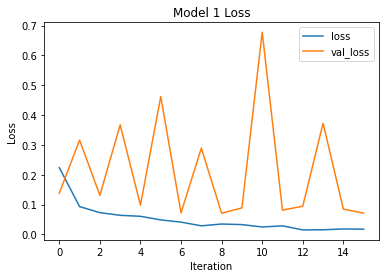

In [163]:
# Plot loss per iteration
# 
plt.plot(model_output_1.history['loss'], label='loss')
plt.plot(model_output_1.history['val_loss'], label='val_loss')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

Text(0.5, 0, 'Iteration')

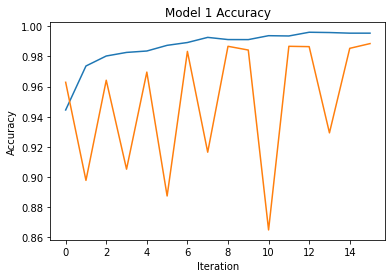

In [164]:
# Plot accuracy per iteration
plt.plot(model_output_1.history['accuracy'], label='acc')
plt.plot(model_output_1.history['val_accuracy'], label='val_acc')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')

##Model using Stochastic Gradient Descent

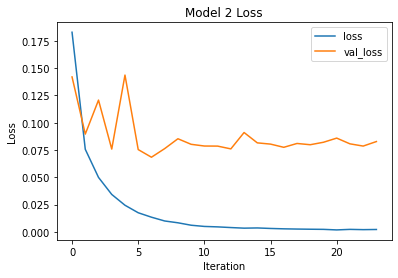

In [165]:
# Plot loss per iteration
plt.plot(model_output_2.history['loss'], label='loss')
plt.plot(model_output_2.history['val_loss'], label='val_loss')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

Text(0.5, 0, 'Iteration')

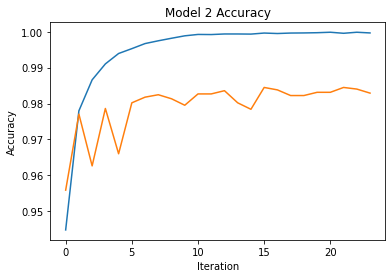

In [166]:
plt.plot(model_output_2.history['accuracy'], label='acc')
plt.plot(model_output_2.history['val_accuracy'], label='val_acc')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')

#Loading the models for predictions 



In [25]:
# Loading models for predictions and averaging

from keras.models import load_model

model_members = []

for i in range(len(model_output)):
 
  model_1 = tf.keras.models.load_model(DATASET_PATH_MODEL+'model1.h5') # load model
  model_members.append('model_1')

  model_2 = tf.keras.models.load_model(DATASET_PATH_MODEL+'model2.h5') # load model
  model_members.append('model_2')

# Predictions on test data 

In [26]:
# Making predictions on test data using model 1 for comparison 

test_generator.reset()
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
pred=model_1.predict(test_generator,verbose=1,steps=test_steps_per_epoch)
predicted_class_indices=np.argmax(pred,axis=1)

# Building a dataframe that maps predictions to true classes

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"image":filenames,
                      "predictions":predictions})
true_and_predicted_labels = pd.merge(df_test[['id','image','masterCategory']], results, on="image")

# Calculating percentage of correct predictions on test data

true_and_predicted_labels['correct_label'] = np.where(true_and_predicted_labels.masterCategory == true_and_predicted_labels.predictions, 1, 0)
print('Model_1 prediction accuracy on test subset:', true_and_predicted_labels['correct_label'].sum()/len(true_and_predicted_labels.predictions)*100)
true_and_predicted_labels.head()

4445/4445 [==============================] - 2252s 507ms/step
Model_1 prediction accuracy on test subset: 99.12260967379078


,id,image,masterCategory,predictions,correct_label
0,49120,49120.jpg,Personal Care,Personal Care,1
1,31996,31996.jpg,Accessories,Accessories,1
2,16535,16535.jpg,Accessories,Accessories,1
3,53441,53441.jpg,Footwear,Footwear,1
4,48318,48318.jpg,Accessories,Accessories,1


In [52]:
#Making predictions on test data using model 1 for comparison 

test_generator.reset()
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
pred2=model_2.predict(test_generator,verbose=1,steps=test_steps_per_epoch)
predicted_class_indices2=np.argmax(pred2,axis=1)

# Building a dataframe that maps predictions to true classes

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions2 = [labels[k] for k in predicted_class_indices2]
filenames2=test_generator.filenames
results2=pd.DataFrame({"image":filenames2,
                       "predictions":predictions2})
true_and_predicted_labels2 = pd.merge(df_test[['id','image','masterCategory']], results2, on="image")

# Calculating percentage of correct predictions on test data

true_and_predicted_labels2['correct_label'] = np.where(true_and_predicted_labels2.masterCategory == true_and_predicted_labels2.predictions, 1, 0)
print('Model_2 prediction accuracy on test subset:', true_and_predicted_labels2['correct_label'].sum()/len(true_and_predicted_labels2.predictions)*100)
true_and_predicted_labels2.head()

4445/4445 [==============================] - 24s 5ms/step
Model_2 prediction accuracy on test subset: 98.85264341957254


,id,image,masterCategory,predictions,correct_label
0,49120,49120.jpg,Personal Care,Personal Care,1
1,31996,31996.jpg,Accessories,Accessories,1
2,16535,16535.jpg,Accessories,Accessories,1
3,53441,53441.jpg,Footwear,Footwear,1
4,48318,48318.jpg,Accessories,Accessories,1


#Examples of predicted images

In [169]:
import cv2
from google.colab.patches import cv2_imshow

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return images_data+img

def load_image(img):
    #resized_fac = 
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    #resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img


##Correctly classified images

(80, 60, 3)


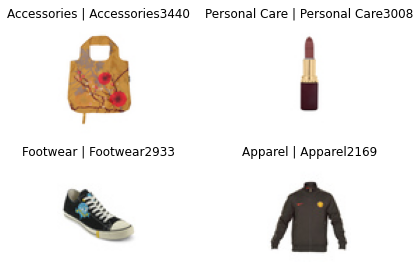

In [179]:
classified_idx = pd.DataFrame()
classified_idx = true_and_predicted_labels.loc[true_and_predicted_labels2['correct_label'] == 1].copy()
# generation of a dictionary of (title, images)
figures = {classified_idx.predictions[i] + " | "+classified_idx.masterCategory[i]+str(i): load_image(row.image) for i, row in classified_idx.sample(4).iterrows()}
#plot of the images in a figure, with 2 rows and 3 columns
print(load_image(classified_idx.iloc[0].image).shape)
plot_figures(figures, 2, 2)

##Misclassified images

(80, 60, 3)


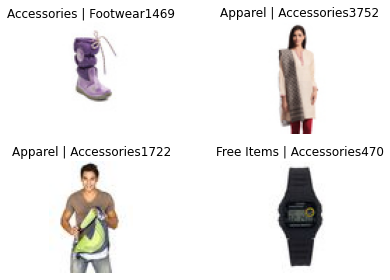

In [161]:

misclassified_idx = pd.DataFrame()
misclassified_idx = true_and_predicted_labels2.loc[true_and_predicted_labels2['correct_label'] != 1].copy()
# generation of a dictionary of (title, images)
figures = {misclassified_idx.predictions[i] + " | "+misclassified_idx.masterCategory[i]+str(i): load_image(row.image) for i, row in misclassified_idx.sample(4).iterrows()}
#plot of the images in a figure, with 2 rows and 3 columns
print(load_image(misclassified_idx.iloc[0].image).shape)
plot_figures(figures, 2, 2)

# Ensemble Learning - Averaging predictions for better generalization

##Predictions on control subset

In [33]:
# Mapping and rescaling control subset of unseen data 

HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

control_generator=datagen.flow_from_dataframe(
                    dataframe=df_control_subset,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=False,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items'],
                    target_size=(HEIGHT,WIDTH))

Found 4445 validated image filenames belonging to 5 classes.


In [53]:
# Model 1 predictions on the control subset


test_steps_per_epoch = np.math.ceil(control_generator.samples / control_generator.batch_size)
labels = (control_generator.classes)
n_samples = control_generator.samples

pred_1=model_1.predict(control_generator,verbose=1,steps=test_steps_per_epoch)
predicted_class1=np.argmax(pred_1,axis=1)

print("Model_1 prediction accuracy  on the control subset:", sum(predicted_class1==labels)/n_samples)

139/139 [==============================] - 19s 133ms/step
Model_1 prediction accuracy  on the control subset: 0.9876265466816648


In [54]:
# Model 2 predictions on the unseen data on control subset


pred_2=model_2.predict(control_generator,verbose=1,steps=test_steps_per_epoch)
predicted_class_indices=np.argmax(pred_2,axis=1)
print("Model_2 prediction accuracy on the control subset:", sum(predicted_class_indices==labels)/n_samples)

139/139 [==============================] - 19s 135ms/step
Model_2 prediction accuracy on the control subset: 0.9858267716535433


In [38]:
#Averaging predictions of two models on unseen data

finalpred=(pred_1+pred_2)/2

def acc(y, pred):
     return np.equal(control_generator.classes, np.argmax(finalpred, axis=1)).mean()

print("Accuracy of averaged predictions: " + str(acc(control_generator.classes, finalpred)))

Accuracy of averaged predictions: 0.9903262092238471


#Classification Report and Confusion Matrix of Averaged Model

Classification Report of averaged model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1129
           1       0.99      1.00      0.99      2140
           2       1.00      1.00      1.00       923
           3       1.00      0.15      0.27        13
           4       0.99      0.97      0.98       240

    accuracy                           0.99      4445
   macro avg       0.99      0.82      0.84      4445
weighted avg       0.99      0.99      0.99      4445

Normalized confusion matrix
[[9.87599646e-01 9.74313552e-03 2.65721878e-03 0.00000000e+00
  0.00000000e+00]
 [3.73831776e-03 9.95794393e-01 0.00000000e+00 0.00000000e+00
  4.67289720e-04]
 [1.08342362e-03 1.08342362e-03 9.97833153e-01 0.00000000e+00
  0.00000000e+00]
 [6.15384615e-01 1.53846154e-01 0.00000000e+00 1.53846154e-01
  7.69230769e-02]
 [2.50000000e-02 4.16666667e-03 0.00000000e+00 0.00000000e+00
  9.70833333e-01]]


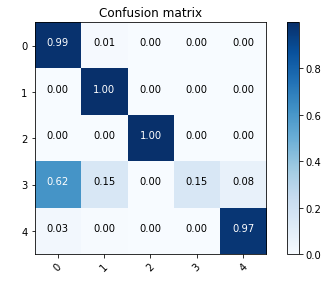

In [56]:
# Plot confusion matrix of averaged model

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

result1 = classification_report(control_generator.classes, np.argmax(finalpred, axis=1))
print("Classification Report of averaged model:",)
print (result1)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, with normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label',color='white')
  plt.xlabel('Predicted label',color='white')
  plt.show()


cm = confusion_matrix(control_generator.classes, np.argmax(finalpred, axis=1))
plot_confusion_matrix(cm, list(range(5)))



Confusion matrix, without normalization
[[1115   11    3    0    0]
 [   8 2131    0    0    1]
 [   1    1  921    0    0]
 [   8    2    0    2    1]
 [   6    1    0    0  233]]


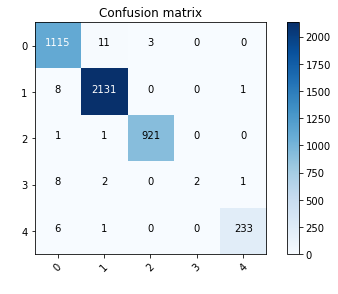

In [180]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label',color='white')
  plt.xlabel('Predicted label',color='white')
  plt.show()


cm = confusion_matrix(control_generator.classes, np.argmax(finalpred, axis=1))
plot_confusion_matrix(cm, list(range(5)))